## Problem 2: Controlling a Rocket Landing: Reachability Analysis

In [102]:
'''
Install required dependencies
'''
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install polytope

In [103]:
import polytope as pt
import numpy as np
import matplotlib.pyplot as plt

'''
Helper Functions
'''
def minkowski_sum(X, Y):
    # Minkowski sum between two polytopes based on 
    # vertex enumeration. So, it's not fast for the
    # high dimensional polytopes with lots of vertices.
    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        # assuming vertices are in (N x d) shape. N # of vertices, d dimension
        V1 = X
        
    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])
    return pt.qhull(np.asarray(V_sum))

def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([])):
    if not B.any():
        return pt.Polytope(Xset.A @ A, Xset.b)
        
    tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
    return pt.Polytope(tmp.A @ A, tmp.b)
    
def Oinf(Xset, A, Wset=pt.Polytope()):
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = pt.reduce(precursor(Omega, A, Wset=Wset).intersect(Omega))
        else:
            Omegap = pt.reduce(precursor(Omega, A).intersect(Omega))
    return Omegap

In [104]:
'''
Do not modify this cell!
'''
from scipy.signal import place_poles

# Parameters
m = 27648
l = 70
J = (1/16)*m*l**2
g = 9.8
TS = 0.1
F_nom = m*g

# Constraints
x_u = np.array([20*np.pi/180, 100])
x_l = np.array([-20*np.pi/180, -100])
u_u = 5*np.pi/180
u_l = -5*np.pi/180

# Model matrices
A = np.array([[1, TS], [0, 1]])
B = np.array([[0], [-TS*(l/(2*J))*F_nom]])

# Constraint matrices
H_x = np.vstack((np.eye(2), -np.eye(2)))
h_x = np.concatenate((x_u, -x_l)).reshape((-1,1))
H_u = np.array([1, -1]).reshape((-1,1))
h_u = np.array([u_u, -u_l]).reshape((-1,1))

In [105]:
X = pt.Polytope(np.array([[1.0, 0], 
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]), 
                np.array([[x_u], 
                          [x_u],
                          [x_u],
                          [x_u]]))
# input constraint

U = pt.Polytope(np.array([1, -1]).reshape(2,1),
                np.array([u_u, u_u]).reshape(2,1))

In [106]:
eps = 0.001
S = pt.box2poly([[-eps, eps], [-eps, eps]])

In [107]:
def max_pos_inv(A, S):
    maxIterations = 500
    # initialization
    Omega_i = S 
    for i in range(maxIterations):
        # compute backward reachable set
        P = precursor(Omega_i, A)
        # intersect with the state constraints
        P = pt.reduce(P).intersect(Omega_i)
        if P == Omega_i:
            Oinf = Omega_i
            break
        else:
            Omega_i = P
    if i == maxIterations:
        converged = 0
    else:
        converged = 1
    return Oinf, converged

### Part a)

 H-representation of the set:  Single polytope 
  [[-0.99877  0.04963] |    [[0.0195 ]
   [ 0.99877 -0.04963] |     [0.0195 ]
   [ 0.3816   0.92433] x <=  [0.03315]
   [-0.3816  -0.92433] |     [0.03315]
   [ 0.92125  0.38897] |     [0.004  ]
   [-0.92125 -0.38897]]|     [0.004  ]]



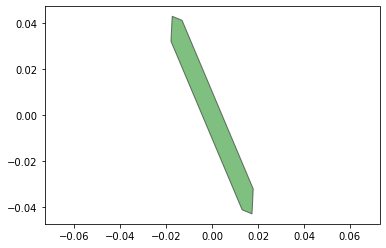

In [139]:


# first design a stabilizing control law:
Poles = np.array([0.5, 0.55])
full_state_feedback = place_poles(A, B, Poles)
K = full_state_feedback.gain_matrix
# closed loop system
Acl = A - B@K


S = X.intersect(pt.Polytope(U.A@ -K, U.b))
Oinf_a, converged = max_pos_inv(Acl,S)
# H-representation of the set
print(" H-representation of the set: ",  Oinf_a) 


fig, ax = plt.subplots()
Oinf_a.plot(ax, color='g', alpha=0.5, linestyle='solid', linewidth=1, edgecolor=None)
ax.autoscale_view()
ax.axis('equal')
plt.show()

### Part b)

 H-representation of the set:  Single polytope 
  [[-0.93189  0.36274] |    [[0.06396]
   [ 0.93189 -0.36274] |     [0.06396]
   [ 0.11915  0.99288] |     [0.06337]
   [-0.11915 -0.99288] x <=  [0.06337]
   [ 0.74154  0.67091] |     [0.01972]
   [-0.74154 -0.67091] |     [0.01972]
   [ 0.85027  0.52635] |     [0.00791]
   [-0.85027 -0.52635]]|     [0.00791]]



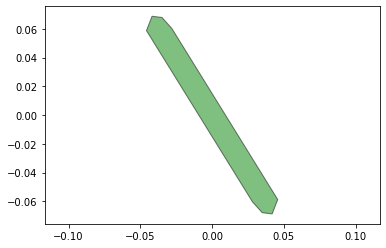

In [129]:
# first design a stabilizing control law:
Poles = np.array([0.7, 0.65])
full_state_feedback = place_poles(A, B, Poles)
K = full_state_feedback.gain_matrix
# closed loop system
Acl = A - B@K


S = X.intersect(pt.Polytope(U.A@ -K, U.b))
Oinf_b, converged = max_pos_inv(Acl,S)
# H-representation of the set
print(" H-representation of the set: ", Oinf_b) 


fig, ax = plt.subplots()
Oinf_b.plot(ax, color='g', alpha=0.5, linestyle='solid', linewidth=1, edgecolor=None)
ax.autoscale_view()
ax.axis('equal')
plt.show()

### Part c)

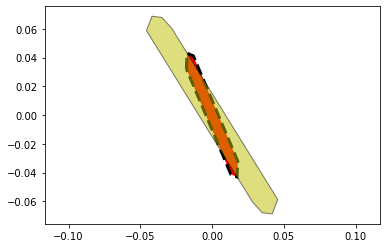

In [110]:

fig, ax = plt.subplots()
Oinf_a.plot(ax, color='r')
Oinf_b.plot(ax, color='y', alpha=0.5, linestyle='solid', linewidth=1, edgecolor=None)
ax.autoscale_view()
ax.axis('equal')
plt.show()


The maximal postive invariant set is the function of the feedback control Law K. As the poles are placed in [0.7, 0.65] instead of [0.5, 0.55], the region of the maximal postive invariant set becomes smaller which means that the region that the system could reach in all future time steps within the horizon if the system start in the region of set. 

### Part d)

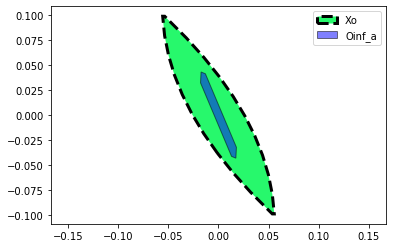

In [114]:
N = 10
d = {}
eps = 0.001
S = pt.box2poly([[-eps, eps], [-eps, eps]])

fig, ax = plt.subplots()
PreS = precursor(S, A, U, B)
for j in range(N):
    d[j]= PreS.intersect(X)
    PreS = precursor(d[j], A, U, B)

X0 = d[N-1]
X0.plot(ax)
Oinf_a.plot(ax, color='b', alpha=0.5, linestyle='solid', linewidth=1, edgecolor=None)
ax.autoscale_view()
ax.axis('equal')
ax.legend(['Xo','Oinf_a'])
plt.show()

The blue region is the maximal positive invariant set from part(a) is a subset of the set of feasible initial states X0 of the MPC controller, it means that if the system start at (a), it could reach all the feasible initial states X0 within the horizon N = 10.  

### Part e)

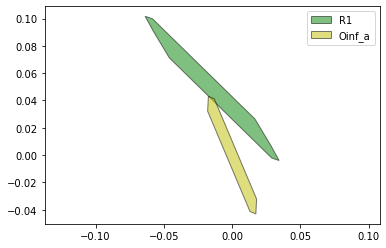

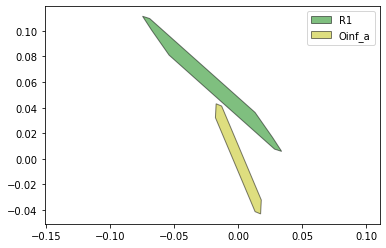

After P = 6, P = 6 step has the largest subset of states in Oinf_a which remians in X0


In [133]:
def precursor_const_u(Xset, A, u, B=np.array([])):
    if not B.any():
        return pt.Polytope(Xset.A @ A, Xset.b)
        
    tmp  = minkowski_sum( Xset, -(B*u).reshape((1,-1)) )
    return pt.Polytope(tmp.A @ A, tmp.b)

P1 = 6

C = {}
S = X.intersect(pt.Polytope(U.A@K, U.b))

fig, ax = plt.subplots()
PreS = precursor(Oinf_a, A, U, B)
for i in range(P1):
    C[i]= PreS.intersect(X)
    PreS = precursor_const_u(C[i], A, u_u, B)

R1 = C[P1-1]
R1.plot(ax, color='g', alpha=0.5, linestyle='solid', linewidth=1, edgecolor=None)
Oinf_a.plot(ax, color='y', alpha=0.5, linestyle='solid', linewidth=1, edgecolor=None)
ax.autoscale_view()
ax.axis('equal')
ax.legend(['R1','Oinf_a'])
plt.show()


P = 7

C = {}
S = X.intersect(pt.Polytope(U.A@K, U.b))

fig, ax = plt.subplots()
PreS = precursor(Oinf_a, A, U, B)
for i in range(P):
    C[i]= PreS.intersect(X)
    PreS = precursor_const_u(C[i], A, u_u, B)

R1 = C[P-1]
R1.plot(ax, color='g', alpha=0.5, linestyle='solid', linewidth=1, edgecolor=None)
Oinf_a.plot(ax, color='y', alpha=0.5, linestyle='solid', linewidth=1, edgecolor=None)
ax.autoscale_view()
ax.axis('equal')
ax.legend(['R1','Oinf_a'])
plt.show()

print("After P = 6, P = 6 step has the largest subset of states in Oinf_a which remians in X0")

### Part f)

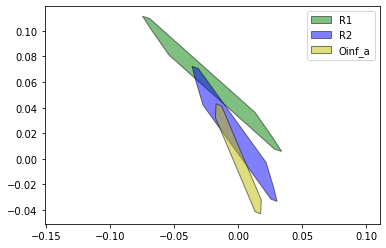

In [138]:
P2 = 3

C = {}
S1 = X.intersect(pt.Polytope(U.A@K, U.b))

fig, ax = plt.subplots()
PreS = precursor(Oinf_a, A, U, B)
for i in range(P2):
    C[i]= PreS.intersect(X)
    PreS = precursor_const_u(C[i], A, u_u, B)

R2 = C[P2-1]
R1.plot(ax, color='g', alpha=0.5, linestyle='solid', linewidth=1, edgecolor=None)
R2.plot(ax, color='B', alpha=0.5, linestyle='solid', linewidth=1, edgecolor=None)
Oinf_a.plot(ax, color='y', alpha=0.5, linestyle='solid', linewidth=1, edgecolor=None)

ax.autoscale_view()
ax.axis('equal')
ax.legend(['R1','R2','Oinf_a'])
plt.show()


Smaller horizon N leads to less computation cost.
P = 3 has a larger subset of states in Oinf_a which remains in X0 than P = 6 does. In other words, we could use the MPC controller from part(d) to maintain stablility the system at time t+6 after the actuator malfunction. 